In [1]:
%%capture
!pip install pydub
!pip install pywt
!pip install noisereduce
!pip install json-tricks

In [3]:
%%capture
import numpy as np
import pandas as pd

import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr
import pywt

import tensorflow as tf
import keras
import sklearn

### DATASET DOWNLOAD & GATHERING

In [4]:
# RAVDESS DOWNLOAD
!gdown https://drive.google.com/uc?id=1G8Vum5TwDXh6eQ6RjyhEkk6y9GmxQxy4
!mv Audio_Speech_Actors_01-24.zip ravdess
!unzip -q -o ravdess -d RAVDESS
  
!gdown https://drive.google.com/uc?id=12HAbGl2iviCDGDluhp3YoiuQBh50y7mS
!unzip -q -o TESS -d TESS

!rm -rf ./TESS/MANIFEST.TXT

Downloading...
From: https://drive.google.com/uc?id=1G8Vum5TwDXh6eQ6RjyhEkk6y9GmxQxy4
To: /content/Audio_Speech_Actors_01-24.zip
100% 208M/208M [00:02<00:00, 75.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=12HAbGl2iviCDGDluhp3YoiuQBh50y7mS
To: /content/TESS.zip
100% 224M/224M [00:01<00:00, 134MB/s]


In [8]:
import os
import shutil

# MAKE NEW DIRECTORIES AND GATHERING FILES
os.makedirs("/content/audiofiles", exist_ok=True)

sample_lengths = []

db1 = "/content/RAVDESS" 
db2 = "/content/TESS"

# RAVDESS
for sub_dir in os.listdir(db1):
  for file in os.listdir(f"{db1}/{sub_dir}"):
    if '.wav' not in file:
      continue
    shutil.copy(f"{db1}/{sub_dir}/{file}", f"/content/audiofiles/{file}")

# TESS
for file in os.listdir(db2):
    if '.wav' not in file:
      continue
    shutil.copy(f"{db2}/{file}", f"/content/audiofiles/{file}")

### DATA PREPROCESSING

In [9]:
# Here, we consider neutral == calm.

# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"
        
        
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num in ["01", "02"]:   return 0 # neutral, or calm.
    elif e_num == "03": return 1 # happy
    elif e_num == "04": return 2 # sad
    elif e_num == "05": return 3 # angry
    elif e_num == "06": return 4 # fear
    else:               return -1 




In [13]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 228864 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/audiofiles'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 

   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]                      

      if emotionfix(name) < 0:
        continue
    
    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
    # Pad for duration equalization.
      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(y = padded_x, y_noise = padded_x, sr=sr)
       
   # Features extraction 
      f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      

   # Filling the data lists  
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 8.4739 minutes


### Data Preprocessing

In [14]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)
f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (3056, 448, 1)
RMS shape: (3056, 448, 1)
MFCCs shape: (3056, 448, 13)


In [15]:
# Save X,Y arrays as lists to json files.
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr , f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

x_data = X.tolist() 
x_path = '/content/drive/MyDrive/speech/x.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = '/content/drive/MyDrive/speech/y.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)


'[[1], [0], [3], [0], [0], [2], [0], [1], [3], [2], [2], [3], [0], [0], [1], [0], [0], [1], [3], [4], [0], [1], [4], [2], [3], [0], [3], [0], [2], [4], [0], [3], [4], [3], [3], [3], [4], [2], [0], [0], [0], [2], [3], [3], [1], [2], [2], [1], [2], [4], [2], [4], [4], [4], [3], [1], [4], [0], [1], [4], [0], [0], [4], [3], [1], [3], [1], [2], [1], [1], [0], [2], [4], [1], [4], [4], [0], [1], [3], [1], [3], [3], [1], [4], [2], [2], [0], [2], [4], [0], [2], [1], [1], [2], [0], [0], [4], [2], [4], [3], [2], [3], [2], [3], [2], [3], [0], [4], [0], [2], [4], [1], [2], [0], [1], [1], [0], [0], [2], [4], [3], [4], [0], [0], [0], [2], [3], [1], [4], [2], [3], [4], [1], [0], [3], [0], [4], [3], [0], [0], [1], [2], [0], [4], [3], [0], [0], [3], [1], [3], [0], [4], [2], [1], [1], [4], [1], [1], [2], [4], [4], [1], [4], [2], [3], [0], [2], [4], [0], [1], [4], [0], [1], [3], [1], [3], [1], [1], [0], [2], [4], [1], [1], [4], [1], [2], [0], [1], [0], [4], [2], [4], [1], [4], [4], [0], [2], [1], [2], [4]

### You can run from here!

In [16]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = '/content/drive/MyDrive/speech/x.json' # FILE SAVE PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '/content/drive/MyDrive/speech/y.json' # FILE SAVE PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [17]:
print(X.shape)
print(Y.shape)

(3056, 448, 15)
(3056, 1)


In [26]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split

x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [19]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

# Save x_test, y_test to JSON.
file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

(2674, 448, 15)
(265, 448, 15)
(117, 448, 15)


'{"__ndarray__": [[4], [3], [4], [0], [1], [1], [4], [4], [2], [4], [1], [1], [2], [2], [3], [1], [4], [1], [4], [4], [3], [2], [1], [0], [1], [2], [2], [2], [0], [2], [1], [4], [0], [3], [3], [3], [3], [0], [1], [2], [1], [0], [1], [0], [4], [4], [3], [4], [1], [3], [0], [0], [3], [3], [2], [3], [4], [3], [4], [2], [4], [0], [1], [1], [0], [2], [1], [0], [0], [0], [2], [4], [4], [3], [1], [0], [4], [0], [3], [4], [4], [0], [3], [0], [3], [1], [1], [2], [4], [0], [1], [1], [4], [4], [1], [1], [3], [1], [4], [3], [3], [0], [2], [2], [1], [4], [4], [1], [1], [3], [4], [0], [2], [0], [3], [2], [3]], "dtype": "int8", "shape": [117, 1], "Corder": true}'

In [20]:
# MODEL DEFINITION and TRAINING

# Initializing the model
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/MyDrive/speech/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])


history = model.fit(x_train, y_train_class, 
                      epochs=340, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])

# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 448, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/340
117/117 [==============================] - 10s 44ms/step - loss: 1.6210 - categorical_accuracy: 0.2330 - val_loss: 1.5684 - val_categorical_accuracy: 0.2302 - lr: 0.0010
Epoch 2/340
117/117 [==============================] - 4s 37ms/step - loss: 1.4511 - categorical_accuracy: 0.3601 - val_loss: 1.4

In [21]:
### VALIDATION
# Compile & train   

model.load_weights(checkpoint_path)

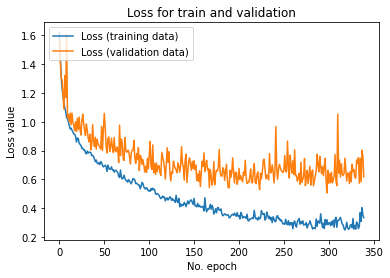

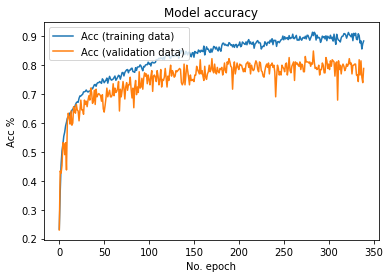

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [23]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

9/9 - 0s - loss: 0.5558 - categorical_accuracy: 0.8491 - 151ms/epoch - 17ms/step


Text(0.5, 51.0, 'Predicted emotion')

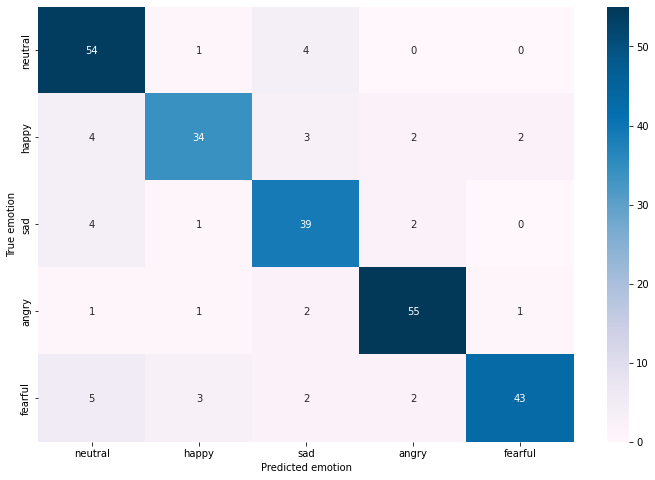

In [27]:
# Validation Confusion matrix

y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'happy', 'sad', 'angry', 'fearful']
columns = ['neutral', 'happy', 'sad', 'angry', 'fearful']
 
cm_df = pd.DataFrame(cm, index, columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [28]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.9153
happy : 0.7556
sad : 0.8478
angry : 0.9167
fearful : 0.7818
